In [1]:
# Cell 1: Import Libraries and Initial Setup

import os
import yaml
import random
from PIL import Image
from ultralytics import YOLO
import torch
import logging
import shutil 
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


yaml_file_full_path = None
trained_model_path = None
experiment_run_dir = None
eval_results_dir = None

In [2]:
# Cell 2: Dataset Pathing and Configuration

dataset_root = r"C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\YOLO"
yaml_file_name = "hand_pose_generated.yaml" 

logger.info(f"Dataset root set to: {dataset_root}")

2025-05-22 10:50:25,827 - INFO - Dataset root set to: C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\YOLO


In [ ]:
# Cell 3: Helper Functions

def create_yolov8_yaml_file(root_path, yaml_name):
    """
    Dynamically creates the YOLOv8 dataset YAML configuration file.
    Includes robust validation for required image and label directories.
    """
    yaml_file_full_path_local = os.path.join(root_path, yaml_name)

    train_proper_images_rel = os.path.join("Proper", "train", "images")
    train_improper_images_rel = os.path.join("Improper", "train", "images")
    val_proper_images_rel = os.path.join("Proper", "valid", "images")
    val_improper_images_rel = os.path.join("Improper", "valid", "images")

    required_image_paths_full = [
        os.path.join(root_path, train_proper_images_rel),
        os.path.join(root_path, train_improper_images_rel),
        os.path.join(root_path, val_proper_images_rel),
        os.path.join(root_path, val_improper_images_rel)
    ]

    logger.info("Validating dataset image directories...")
    for full_path in required_image_paths_full:
        if not os.path.isdir(full_path):
            logger.critical(f"FATAL ERROR: Required dataset image directory not found: {full_path}")
            logger.critical("Please ensure 'dataset_root' is correct and your dataset structure matches the expected format.")
            raise FileNotFoundError(f"Dataset images directory missing: {full_path}")
        else:
            logger.info(f"   Verified: {full_path}")

    required_label_paths_full = [
        os.path.join(root_path, "Proper", "train", "labels"),
        os.path.join(root_path, "Improper", "train", "labels"),
        os.path.join(root_path, "Proper", "valid", "labels"),
        os.path.join(root_path, "Improper", "valid", "labels")
    ]

    logger.info("Validating dataset label directories...")
    for full_path in required_label_paths_full:
        if not os.path.isdir(full_path):
            logger.warning(f"WARNING: Corresponding labels directory not found: {full_path}")
            logger.warning("This may lead to training errors if labels are missing for detected images.")
        else:
            logger.info(f"   Verified: {full_path}")

    yaml_data = {
        'path': root_path,
        'train': [
            train_proper_images_rel,
            train_improper_images_rel
        ],
        'val': [
            val_proper_images_rel,
            val_improper_images_rel
        ],
        'nc': 2,
        'names': ['Proper', 'Improper'],
        'kpt_shape': [21, 3],
        'flip_idx': list(range(21))
    }

    try:
        with open(yaml_file_full_path_local, 'w') as outfile:
            yaml.dump(yaml_data, outfile, default_flow_style=False, sort_keys=False)
        logger.info(f"Successfully created YOLOv8 YAML file at: {yaml_file_full_path_local}")
        return yaml_file_full_path_local
    except IOError as e:
        logger.critical(f"FATAL ERROR: Could not write YAML file {yaml_file_full_path_local}: {e}", exc_info=True)
        raise

def display_random_images_with_labels_popup(class_directories_map, num_images_per_class=1):
    """Displays a few random images from specified class directories in pop-up windows."""
    for class_name, directory in class_directories_map.items():
        if not os.path.isdir(directory):
            logger.warning(f"Skipping image display for class '{class_name}': Directory not found: {directory}")
            continue

        image_files = [f for f in os.listdir(directory)
                        if os.path.isfile(os.path.join(directory, f))
                        and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            logger.info(f"No images found in {directory} for class '{class_name}' to display.")
            continue

        random_images = random.sample(image_files, min(num_images_per_class, len(image_files)))

        for img_file in random_images:
            img_path = os.path.join(directory, img_file)
            try:
                img = Image.open(img_path)
                img.show(title=f"Sample Training Image - Class: {class_name} - {img_file}")
                logger.info(f"Displayed: {img_path} (Class: {class_name})")
            except Exception as e:
                logger.error(f"Error loading or displaying image {img_path}: {e}")

def get_random_image_paths(directory_list, num_images_per_dir=1):
    """Collects random image paths from a list of directories for prediction."""
    all_image_paths = []
    for directory in directory_list:
        if not os.path.isdir(directory):
            logger.warning(f"Prediction path not found: {directory}. Skipping.")
            continue
        image_files = [os.path.join(directory, f) for f in os.listdir(directory)
                        if os.path.isfile(os.path.join(directory, f))
                        and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if image_files:
            all_image_paths.extend(random.sample(image_files, min(num_images_per_dir, len(image_files))))
    return all_image_paths

In [ ]:
# Cell 4: Model and Training Parameters

model_variant = 'yolov8n-pose.pt' 
                                 
project_name = 'runs/hand_pose_training' 
experiment_name_prefix = 'yolov8n_custom_pose' 

epochs = 25     
imgsz = 320     
batch_size = 4  
workers = 0     
                
patience = 10   
lr0 = 0.01      
lrf = 0.01      

augment = True  

# Detailed augmentation parameters 
hsv_h = 0.015   
hsv_s = 0.7     
hsv_v = 0.4    
degrees = 0.0   
translate = 0.1 
scale = 0.5    
flipud = 0.0    
fliplr = 0.5    
mosaic = 1.0    
mixup = 0.0     
copy_paste = 0.0 

seed = 42       

prediction_confidence_threshold = 0.5 
num_sample_predictions = 4            

logger.info("\n--- Model and Training Parameters Configured ---")

2025-05-22 11:05:37,549 - INFO - 
--- Model and Training Parameters Configured ---


In [ ]:
# Cell 5: Actual Building and Training Model

logger.info("\n--- Building and Training the Model ---")
logger.info(f"Current working directory: {os.getcwd()}")


if torch.cuda.is_available():
    device = 'cuda'
    logger.info("CUDA (GPU) is available! Using GPU for training and inference.")
else:
    device = 'cpu'
    logger.warning("CUDA (GPU) not available. Using CPU. Training and inference will be significantly slower.")
    logger.warning(f"Consider reducing 'imgsz' ({imgsz}), 'batch_size' ({batch_size}), and 'epochs' ({epochs}).")
    logger.warning(f"Mosaic augmentation ({mosaic}) might also slow down CPU training; consider reducing it.")
    workers = 0 
    logger.info(f"Set 'workers' to {workers} for Windows CPU stability.")


try:
    yaml_file_full_path = create_yolov8_yaml_file(dataset_root, yaml_file_name)
    logger.info(f"YOLOv8 YAML file successfully configured at: {yaml_file_full_path}")
except Exception as e:
    logger.critical(f"FATAL ERROR during YAML file creation or dataset validation: {e}", exc_info=True)
    raise 


model = None 
try:
    logger.info(f"Initializing YOLO model with variant: {model_variant}")
    model = YOLO(model_variant)  
    logger.info("YOLO model loaded successfully.")

    
    logger.info("\n--- YOLOv8 Model Summary (Before Training) ---")
    model.info(verbose=False)
    logger.info("Summary of the loaded model architecture printed above.")
    logger.info("-----------------------------------------------\n")

    logger.info(f"Starting training for {epochs} epochs...")
    logger.info(f"Results will be saved to: {project_name}/{experiment_name_prefix}_<timestamp>")

    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    current_experiment_name = f"{experiment_name_prefix}_{timestamp}"
    experiment_run_dir = os.path.join(project_name, current_experiment_name)

   
    results = model.train(
        data=yaml_file_full_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch_size,
        device=device,
        workers=workers,
        project=project_name,
        name=current_experiment_name,
        patience=patience,
        lr0=lr0,
        lrf=lrf,
        augment=augment,
        seed=seed,
        hsv_h=hsv_h, hsv_s=hsv_s, hsv_v=hsv_v,
        degrees=degrees, translate=translate, scale=scale,
        flipud=flipud, fliplr=fliplr,
        mosaic=mosaic, mixup=mixup, copy_paste=copy_paste,
        val=True 
    )
    logger.info("YOLOv8 training completed.")

   
    experiment_run_dir = results.save_dir
    logger.info(f"All training artifacts are saved in: {experiment_run_dir}")

    
    trained_model_path = os.path.join(experiment_run_dir, 'weights', 'best.pt')
    if not os.path.exists(trained_model_path):
        logger.warning(f"Best model ('best.pt') not found in {os.path.join(experiment_run_dir, 'weights')}.")
        logger.warning("This can happen if training stopped very early or if 'best.pt' wasn't saved. Falling back to 'last.pt'.")
        last_model_path = os.path.join(experiment_run_dir, 'weights', 'last.pt')
        if os.path.exists(last_model_path):
            trained_model_path = last_model_path
        else:
            logger.error("Neither 'best.pt' nor 'last.pt' found. Cannot proceed with evaluation or prediction.")
            trained_model_path = None
except Exception as e:
    logger.critical(f"FATAL ERROR during YOLOv8 training: {e}", exc_info=True)
    if 'model' in locals() and hasattr(model, 'trainer') and hasattr(model.trainer, 'save_dir'):
        experiment_run_dir = str(model.trainer.save_dir)
        logger.info(f"Partial training results might be available in: {experiment_run_dir}")
    raise 

2025-05-22 11:05:41,233 - INFO - 
--- Building and Training the Model ---
2025-05-22 11:05:41,233 - INFO - Current working directory: c:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset
2025-05-22 11:05:41,233 - WARNING - CUDA (GPU) not available. Using CPU. Training and inference will be significantly slower.
2025-05-22 11:05:41,245 - WARNING - Consider reducing 'imgsz' (320), 'batch_size' (4), and 'epochs' (25).
2025-05-22 11:05:41,245 - WARNING - Mosaic augmentation (1.0) might also slow down CPU training; consider reducing it.
2025-05-22 11:05:41,246 - INFO - Set 'workers' to 0 for Windows CPU stability.
2025-05-22 11:05:41,247 - INFO - Validating dataset image directories...
2025-05-22 11:05:41,248 - INFO -    Verified: C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\YOLO\Proper\train\images
2025-05-22 11:05:41,249 - INFO -    Verified: C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\YOL

New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.108  Python-3.12.7 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
engine\trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\YOLO\hand_pose_generated.yaml, epochs=25, time=None, patience=10, batch=4, imgsz=320, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=runs/hand_pose_training, name=yolov8n_custom_pose_20250522_110541, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buff

train: Scanning C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\YOLO\Improper\train\labels.cache... 5780 images, 33 backgrounds, 0 corrupt: 100%|██████████| 5780/5780 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\YOLO\Improper\valid\labels.cache... 168 images, 1 backgrounds, 0 corrupt: 100%|██████████| 168/168 [00:00<?, ?it/s]


Plotting labels to runs\hand_pose_training\yolov8n_custom_pose_20250522_110541\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\hand_pose_training\yolov8n_custom_pose_20250522_110541
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      1.363      10.16     0.6186       1.32      1.445          8        320: 100%|██████████| 1445/1445 [14:50<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]

                   all        168        170        0.9      0.882       0.95      0.607     0.0163    0.00588   0.000224   4.48e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      1.313      9.177     0.4839      1.037      1.394          9        320: 100%|██████████| 1445/1445 [13:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.32it/s]

                   all        168        170       0.93      0.937      0.968      0.623     0.0268     0.0235    0.00145   0.000145



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G      1.288      8.641     0.4449     0.9842      1.365          7        320: 100%|██████████| 1445/1445 [12:51<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.33it/s]

                   all        168        170      0.946      0.906      0.975      0.677      0.138      0.124     0.0263    0.00357



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G      1.246      8.266     0.4261     0.9299       1.34          7        320: 100%|██████████| 1445/1445 [13:41<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  2.09it/s]

                   all        168        170      0.943      0.965      0.979      0.664      0.192      0.159     0.0464    0.00613



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      1.193      7.855     0.4108     0.8614      1.303         10        320: 100%|██████████| 1445/1445 [13:26<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]

                   all        168        170      0.932      0.947      0.963      0.679      0.278      0.253     0.0902     0.0143



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G      1.141      7.468     0.3974     0.8052      1.273          9        320: 100%|██████████| 1445/1445 [13:30<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  1.95it/s]

                   all        168        170      0.958      0.976      0.975      0.681      0.458      0.394       0.21     0.0505



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G      1.121      7.148     0.3872     0.7882       1.26          8        320: 100%|██████████| 1445/1445 [14:04<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  2.02it/s]

                   all        168        170      0.976       0.94      0.976      0.679      0.417      0.376      0.281     0.0807



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G      1.098        6.9     0.3804     0.7663      1.243          5        320: 100%|██████████| 1445/1445 [16:41<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]

                   all        168        170      0.975        0.9      0.969      0.677      0.612      0.512       0.41      0.122



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      1.081        6.7     0.3755     0.7421      1.236         10        320: 100%|██████████| 1445/1445 [16:57<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:11<00:00,  1.80it/s]

                   all        168        170      0.953      0.941       0.98      0.703      0.594        0.5       0.38      0.115



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      1.056      6.529     0.3743     0.7217      1.222          9        320: 100%|██████████| 1445/1445 [20:35<00:00,  1.17it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:17<00:00,  1.17it/s]

                   all        168        170      0.955      0.976      0.989      0.716      0.588      0.547      0.381      0.104



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G      1.043      6.316     0.3592     0.7144      1.216          6        320: 100%|██████████| 1445/1445 [22:51<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]

                   all        168        170      0.941      0.942      0.976      0.701      0.651      0.576      0.468      0.132



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      1.024      6.182     0.3576     0.6876      1.203          7        320: 100%|██████████| 1445/1445 [17:01<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:12<00:00,  1.69it/s]

                   all        168        170      0.959      0.935      0.972      0.715      0.636      0.576      0.434      0.137



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G      1.014      6.021     0.3583     0.6813        1.2          9        320: 100%|██████████| 1445/1445 [19:24<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.56it/s]

                   all        168        170      0.951      0.953      0.989      0.723      0.739       0.65      0.573      0.174



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G     0.9885      5.868     0.3524     0.6598      1.187         10        320: 100%|██████████| 1445/1445 [13:50<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  2.03it/s]

                   all        168        170      0.925      0.976      0.984       0.72      0.731      0.665      0.609      0.203



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G     0.9763      5.774     0.3476     0.6497       1.18          8        320: 100%|██████████| 1445/1445 [13:54<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.24it/s]

                   all        168        170      0.953      0.959      0.985      0.724      0.724      0.676       0.59      0.195


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G     0.7918      3.863     0.1013     0.4215      1.051          4        320: 100%|██████████| 1445/1445 [24:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:12<00:00,  1.71it/s]

                   all        168        170      0.948       0.97      0.981      0.723      0.733      0.688      0.656      0.238



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G     0.7533      3.601    0.08699     0.3961      1.033          4        320: 100%|██████████| 1445/1445 [26:06<00:00,  1.08s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  2.01it/s]

                   all        168        170      0.932      0.975      0.984       0.75      0.789      0.718      0.724      0.307



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G     0.7322      3.365    0.07791     0.3846      1.021          4        320: 100%|██████████| 1445/1445 [15:33<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  2.05it/s]

                   all        168        170      0.969      0.941      0.988       0.75      0.787      0.759      0.725       0.32



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G     0.7058      3.168    0.07338      0.366      1.004          4        320: 100%|██████████| 1445/1445 [15:00<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  1.99it/s]

                   all        168        170      0.968      0.959      0.984      0.735      0.823      0.771      0.743      0.355



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/25         0G     0.6737      3.024    0.07367     0.3536     0.9914          4        320: 100%|██████████| 1445/1445 [14:21<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]

                   all        168        170      0.982      0.963      0.988      0.744      0.813      0.753      0.739      0.353



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G     0.6517       2.87    0.07079     0.3431     0.9765          4        320: 100%|██████████| 1445/1445 [14:46<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  1.97it/s]

                   all        168        170       0.97      0.963      0.984      0.743      0.817      0.759       0.75      0.379



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G     0.6309      2.773    0.07049      0.329     0.9686          4        320: 100%|██████████| 1445/1445 [15:49<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.52it/s]

                   all        168        170      0.968      0.965      0.985      0.752      0.785      0.759      0.738       0.39



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G     0.6067      2.696    0.07063     0.3225     0.9563          4        320: 100%|██████████| 1445/1445 [19:17<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:12<00:00,  1.66it/s]

                   all        168        170      0.975      0.971      0.986      0.756      0.823      0.767      0.759      0.411



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G     0.5854       2.61    0.06738      0.311     0.9518          5        320: 100%|██████████| 1445/1445 [22:11<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:23<00:00,  1.14s/it]

                   all        168        170      0.965      0.963      0.984      0.767       0.83      0.771      0.793      0.434



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G     0.5763      2.522    0.06525     0.3017      0.944          4        320: 100%|██████████| 1445/1445 [17:29<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  2.09it/s]

                   all        168        170      0.959       0.97      0.986      0.765      0.825      0.765      0.779      0.426



25 epochs completed in 7.130 hours.
Optimizer stripped from runs\hand_pose_training\yolov8n_custom_pose_20250522_110541\weights\last.pt, 7.0MB
Optimizer stripped from runs\hand_pose_training\yolov8n_custom_pose_20250522_110541\weights\best.pt, 7.0MB

Validating runs\hand_pose_training\yolov8n_custom_pose_20250522_110541\weights\best.pt...
Ultralytics 8.3.108  Python-3.12.7 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
YOLOv8n-pose summary (fused): 81 layers, 3,379,691 parameters, 0 gradients, 9.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|          | 0/21 [00:00<?, ?it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   5%|▍         | 1/21 [00:00<00:10,  1.84it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  10%|▉         | 2/21 [00:01<00:11,  1.71it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  14%|█▍        | 3/21 [00:01<00:10,  1.72it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  19%|█▉        | 4/21 [00:02<00:09,  1.75it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  24%|██▍       | 5/21 [00:02<00:08,  1.91it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  29%|██▊       | 6/21 [00:03<00:07,  2.03it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  33%|███▎      | 7/21 [00:03<00:07,  1.86it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  38%|███▊      | 8/21 [00:04<00:06,  2.00it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  43%|████▎     | 9/21 [00:04<00:05,  2.01it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  48%|████▊     | 10/21 [00:05<00:05,  2.07it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  52%|█████▏    | 11/21 [00:05<00:04,  2.13it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  57%|█████▋    | 12/21 [00:06<00:04,  2.20it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  62%|██████▏   | 13/21 [00:06<00:03,  2.19it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  67%|██████▋   | 14/21 [00:06<00:03,  2.20it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  71%|███████▏  | 15/21 [00:07<00:02,  2.01it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  76%|███████▌  | 16/21 [00:07<00:02,  2.05it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  81%|████████  | 17/21 [00:08<00:01,  2.10it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  86%|████████▌ | 18/21 [00:08<00:01,  2.13it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  90%|█████████ | 19/21 [00:09<00:00,  2.18it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):  95%|█████████▌| 20/21 [00:09<00:00,  2.26it/s]

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  2.06it/s]


                   all        168        170      0.965      0.963      0.984      0.767       0.83      0.771      0.793      0.434
                Proper        167        170      0.965      0.963      0.984      0.767       0.83      0.771      0.793      0.434
Speed: 1.3ms preprocess, 49.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\hand_pose_training\yolov8n_custom_pose_20250522_110541


2025-05-22 18:14:00,973 - INFO - YOLOv8 training completed.
2025-05-22 18:14:00,989 - INFO - All training artifacts are saved in: runs\hand_pose_training\yolov8n_custom_pose_20250522_110541


In [ ]:
# Cell 6: Evaluation Metrics and Model Summary

logger.info("\n--- Starting Model Evaluation and Metrics Analysis ---")


if trained_model_path and os.path.exists(trained_model_path):
    logger.info("\n--- YOLOv8 Model Summary (After Training) ---")
    try:
        summary_model = YOLO(trained_model_path)
        summary_model.info(verbose=False)
        logger.info("Summary of the trained model architecture printed above.")
    except Exception as e:
        logger.error(f"Error printing trained model summary: {e}")
    logger.info("----------------------------------------------\n")
else:
    logger.warning("Trained model path not found, skipping model summary after training.")


if trained_model_path and os.path.exists(trained_model_path):
    logger.info(f"Performing final evaluation of the best trained model: {trained_model_path}")
    try:
        model_eval = YOLO(trained_model_path)
        metrics = model_eval.val(
            data=yaml_file_full_path,
            imgsz=imgsz,
            batch=batch_size,
            device=device,
            project=project_name,
            name=current_experiment_name + "_final_eval", 
            plots=True 
        )
        logger.info("\n--- Final Evaluation Metrics (on Validation Set) ---")
        logger.info(f"   Bounding Box Metrics:")
        logger.info(f"     mAP50-95 (BBox): {metrics.box.map:.4f}")
        logger.info(f"     mAP50 (BBox): {metrics.box.map50:.4f}")
        logger.info(f"     Precision (BBox): {metrics.box.mp:.4f}")
        logger.info(f"     Recall (BBox): {metrics.box.mr:.4f}")

        logger.info(f"   Pose Estimation Metrics (Keypoints - OKS-based):")
        logger.info(f"     mAP50-95 (Keypoints): {metrics.pose.map:.4f}")
        logger.info(f"     mAP50 (Keypoints): {metrics.pose.map50:.4f}")
        logger.info(f"     Best Accuracy (mAP50 Keypoints): {metrics.pose.map50:.4f}") 
        logger.info(f"     Inference speed during evaluation: {metrics.speed['inference']:.2f} ms/img (from YOLOv8's validation)")


        logger.info("\n**Pseudo-code for a PCK calculation function:**")
        logger.info("```python")
        logger.info("def calculate_pck(ground_truth_keypoints, predicted_keypoints, thresholds=[5, 10, 15, 20]):")
        logger.info("    pck_results = {}")
        logger.info("    for threshold_px in thresholds: # Assuming pixel thresholds for simplicity here")
        logger.info("        correct_count = 0")
        logger.info("        total_visible_gt_kpts = 0")
        logger.info("        for gt_obj, pred_obj in zip(ground_truth_keypoints, predicted_keypoints):")
        logger.info("            # Assuming each object has keypoints in a list/array with (x, y, visibility)")
        logger.info("            for i in range(min(len(gt_obj), len(pred_obj))):")
        logger.info("                gt_kpt = gt_obj[i]")
        logger.info("                pred_kpt = pred_obj[i]")
        logger.info("                if gt_kpt[2] == 1: # Check if ground truth keypoint is visible")
        logger.info("                    total_visible_gt_kpts += 1")
        logger.info("                    distance = np.sqrt((pred_kpt[0] - gt_kpt[0])**2 + (pred_kpt[1] - gt_kpt[1])**2)")
        logger.info("                    # For a robust PCK, you'd normalize 'distance' here, e.g., by object scale")
        logger.info("                    # normalized_distance = distance / object_scale")
        logger.info("                    if distance <= threshold_px: # Simple pixel-based threshold")
        logger.info("                        correct_count += 1")
        logger.info("        pck_value = (correct_count / total_visible_gt_kpts) * 100 if total_visible_gt_kpts > 0 else 0")
        logger.info(f"        pck_results[f'PCK@{threshold_px}px'] = pck_value")
        logger.info("    return pck_results")
        logger.info("```")
        logger.info("--------------------------------------------------------------------------------\n")

        eval_results_dir = metrics.save_dir # Store the evaluation results directory
        logger.info(f"Detailed evaluation results (including plots) saved to: {eval_results_dir}")

    except Exception as e:
        logger.error(f"Error during final model evaluation: {e}", exc_info=True)
else:
    logger.warning("No trained model found to perform final explicit evaluation.")

2025-05-22 18:14:46,885 - INFO - 
--- Starting Model Evaluation and Metrics Analysis ---
2025-05-22 18:14:46,885 - INFO - 
--- YOLOv8 Model Summary (After Training) ---
2025-05-22 18:14:47,188 - INFO - Summary of the trained model architecture printed above.
2025-05-22 18:14:47,188 - INFO - ----------------------------------------------

2025-05-22 18:14:47,188 - INFO - Performing final evaluation of the best trained model: runs\hand_pose_training\yolov8n_custom_pose_20250522_110541\weights\best.pt


Ultralytics 8.3.108  Python-3.12.7 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
YOLOv8n-pose summary (fused): 81 layers, 3,379,691 parameters, 0 gradients, 9.6 GFLOPs


val: Scanning C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\YOLO\Improper\valid\labels.cache... 168 images, 1 backgrounds, 0 corrupt: 100%|██████████| 168/168 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]


                   all        168        170      0.965      0.963      0.984      0.767       0.83      0.771      0.793      0.434
                Proper        167        170      0.965      0.963      0.984      0.767       0.83      0.771      0.793      0.434
Speed: 1.1ms preprocess, 66.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\hand_pose_training\yolov8n_custom_pose_20250522_110541_final_eval


2025-05-22 18:15:08,633 - INFO - 
--- Final Evaluation Metrics (on Validation Set) ---
2025-05-22 18:15:08,633 - INFO -    Bounding Box Metrics:
2025-05-22 18:15:08,633 - INFO -      mAP50-95 (BBox): 0.7666
2025-05-22 18:15:08,633 - INFO -      mAP50 (BBox): 0.9838
2025-05-22 18:15:08,633 - INFO -      Precision (BBox): 0.9647
2025-05-22 18:15:08,633 - INFO -      Recall (BBox): 0.9633
2025-05-22 18:15:08,633 - INFO -    Pose Estimation Metrics (Keypoints - OKS-based):
2025-05-22 18:15:08,649 - INFO -      mAP50-95 (Keypoints): 0.4336
2025-05-22 18:15:08,651 - INFO -      mAP50 (Keypoints): 0.7925
2025-05-22 18:15:08,652 - INFO -      Best Accuracy (mAP50 Keypoints): 0.7925
2025-05-22 18:15:08,653 - INFO -      Inference speed during evaluation: 66.06 ms/img (from YOLOv8's validation)
2025-05-22 18:15:08,654 - INFO - 
--- Custom PCK (Percentage of Correct Keypoints) Metrics ---
2025-05-22 18:15:08,655 - INFO - NOTE: YOLOv8's `model.val()` does not directly output PCK@N metrics (e.g., P

In [ ]:
# Cell 7: Plots and Visualizations

logger.info("\n--- Generating Plots and Visualizations ---")

if experiment_run_dir and os.path.exists(experiment_run_dir):
    logger.info(f"Generating summary report and custom plots for run: {experiment_run_dir}")
    plot_training_results(experiment_run_dir) 

    logger.info(f"YOLOv8's default plots (e.g., results.png, confusion_matrix.png, F1_curve.png, P_curve.png, R_curve.png, confusion_matrix_normalized.png) are in: {experiment_run_dir}")

    results_png_path = os.path.join(experiment_run_dir, "results.png")
    if os.path.exists(results_png_path):
        try:
            img = Image.open(results_png_path)
            img.show(title=f"YOLOv8 Training Results Summary - {current_experiment_name}")
            logger.info(f"Displayed YOLOv8's 'results.png' from: {results_png_path}")
        except Exception as e:
            logger.error(f"Could not display results.png from {results_png_path}: {e}")
    else:
        logger.warning(f"YOLOv8's 'results.png' not found at {results_png_path}. It might not have been generated yet.")

    
    if eval_results_dir and os.path.exists(eval_results_dir) and eval_results_dir != experiment_run_dir:
        val_results_png = os.path.join(eval_results_dir, "results.png")
        if os.path.exists(val_results_png):
            try:
                img = Image.open(val_results_png)
                img.show(title=f"Final Validation Results - {current_experiment_name}_final_eval")
                logger.info(f"Displayed final validation 'results.png' from: {val_results_png}")
            except Exception as e:
                logger.error(f"Could not display final validation results.png: {e}")
else:
    logger.warning("Experiment run directory not found. Cannot generate plots or performance summary.")

2025-05-22 18:16:37,990 - INFO - 
--- Generating Plots and Visualizations ---
2025-05-22 18:16:38,006 - INFO - Generating summary report and custom plots for run: runs\hand_pose_training\yolov8n_custom_pose_20250522_110541
2025-05-22 18:16:39,073 - INFO - Saved custom training plots to runs\hand_pose_training\yolov8n_custom_pose_20250522_110541\custom_training_plots.png
2025-05-22 18:16:39,075 - INFO - YOLOv8's default plots (e.g., results.png, confusion_matrix.png, F1_curve.png, P_curve.png, R_curve.png, confusion_matrix_normalized.png) are in: runs\hand_pose_training\yolov8n_custom_pose_20250522_110541
2025-05-22 18:16:39,783 - INFO - Displayed YOLOv8's 'results.png' from: runs\hand_pose_training\yolov8n_custom_pose_20250522_110541\results.png


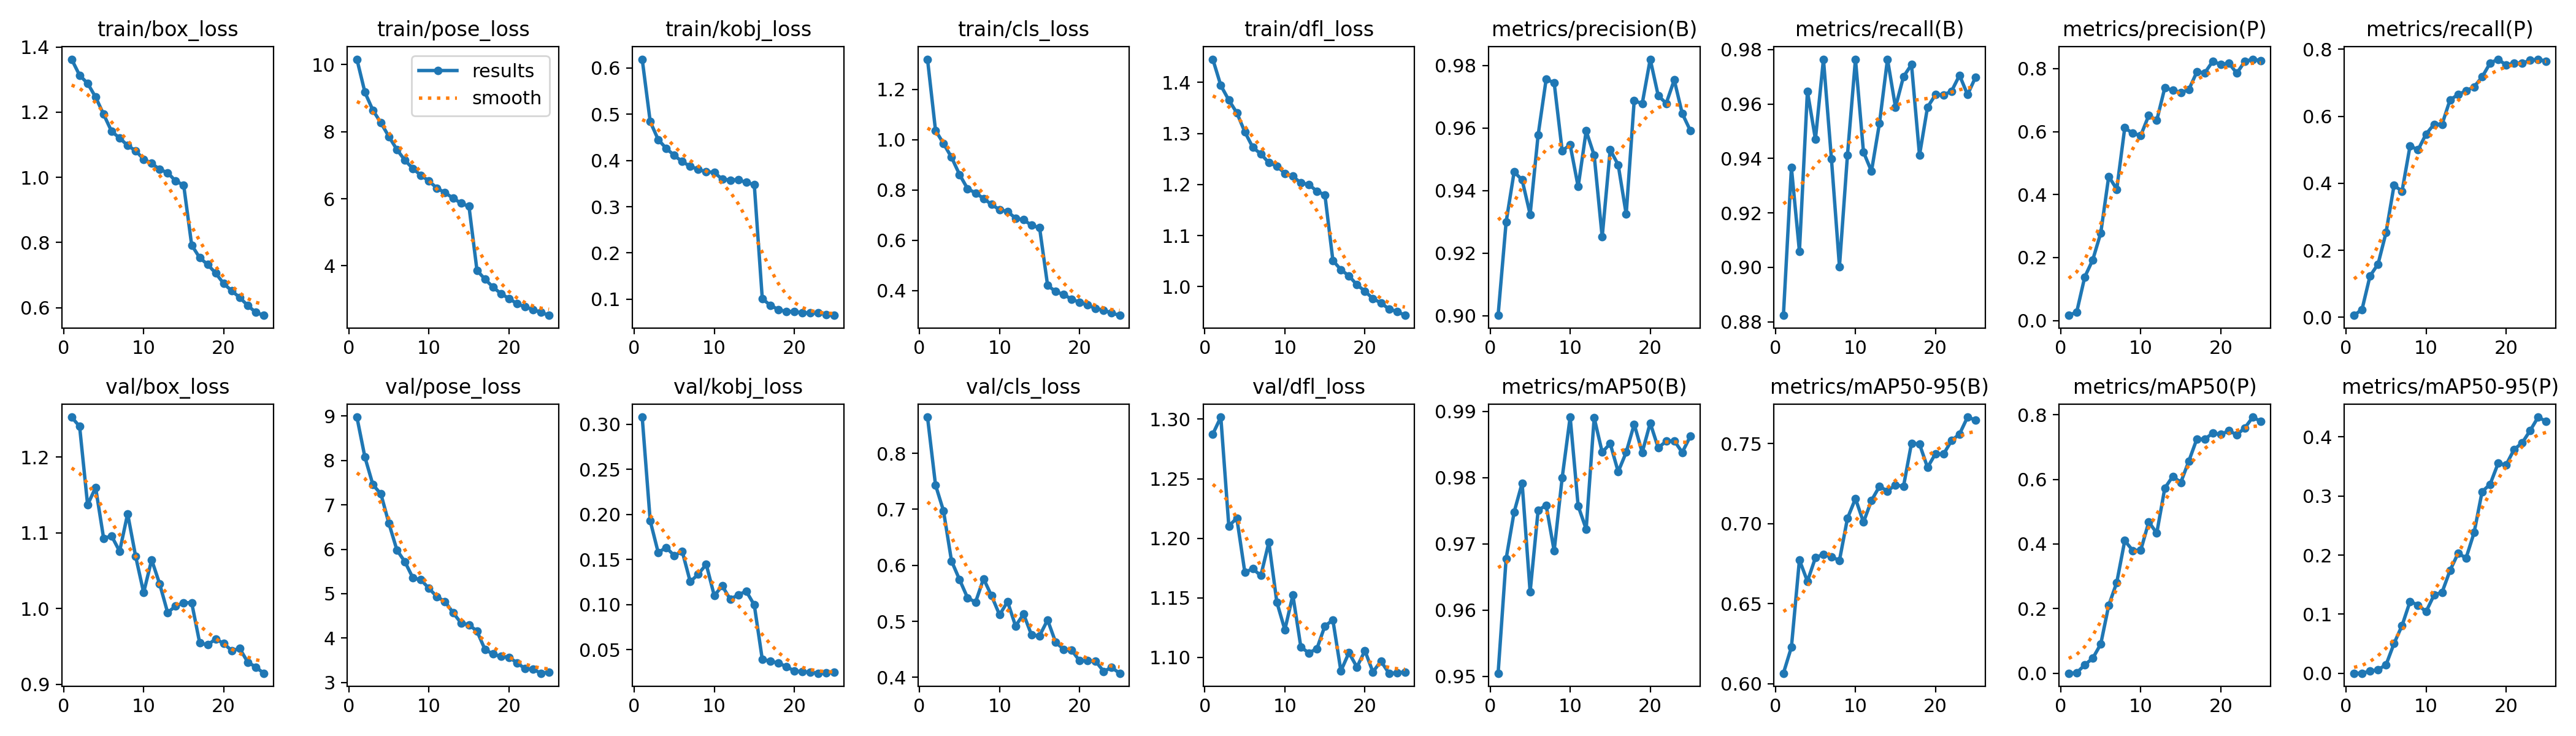

In [ ]:
# Cell 8: Prediction on Test Images

logger.info("\n--- Starting Prediction on Example Test Images ---")

prediction_model = None
if trained_model_path and os.path.exists(trained_model_path):
    logger.info(f"Loading trained model for predictions: {trained_model_path}")
    prediction_model = YOLO(trained_model_path)

    
    val_proper_images_dir = os.path.join(dataset_root, "Proper", "valid", "images")
    val_improper_images_dir = os.path.join(dataset_root, "Improper", "valid", "images")

    image_paths_to_predict = get_random_image_paths(
        [val_proper_images_dir, val_improper_images_dir],
        num_sample_predictions // 2 
    )

    if not image_paths_to_predict:
        logger.warning("No images found for prediction example. Please check your validation directories.")
    else:
        logger.info(f"Predicting on {len(image_paths_to_predict)} example images: {[os.path.basename(p) for p in image_paths_to_predict]}")
        try:
            prediction_results = prediction_model.predict(
                source=image_paths_to_predict,
                save=True, 
                show=False, 
                conf=prediction_confidence_threshold, 
                project=project_name, 
                name=current_experiment_name + "_preds", 
                show_labels=True,
                show_conf=True, 
                show_boxes=True, 
                line_width=2, 
            )

            pred_save_dir = prediction_model.predictor.save_dir if hasattr(prediction_model, 'predictor') else 'default prediction folder'
            logger.info(f"Prediction results (annotated images) saved in: {pred_save_dir}")

            for i, r in enumerate(prediction_results):
                logger.info(f"--- Prediction Result for image: {os.path.basename(r.path)} ---")
                if r.boxes:
                    logger.info(f"   Detected {len(r.boxes)} bounding box(es).")
                    for box in r.boxes:
                        cls_name = prediction_model.names[int(box.cls)]
                        conf = box.conf.item()
                        logger.info(f"     Class: {cls_name}, Confidence: {conf:.2f}, Box: {box.xyxy.tolist()[0]}")
                if r.keypoints is not None and len(r.keypoints.xy) > 0:
                    logger.info(f"   Detected keypoints for {len(r.keypoints.xy)} object(s).")

        except Exception as e:
            logger.error(f"Error during prediction on example images: {e}", exc_info=True)
else:
    logger.warning("No trained model found to run predictions on example images.")

2025-05-22 18:17:19,519 - INFO - 
--- Starting Prediction on Example Test Images ---
2025-05-22 18:17:19,527 - INFO - Loading trained model for predictions: runs\hand_pose_training\yolov8n_custom_pose_20250522_110541\weights\best.pt
2025-05-22 18:17:20,137 - INFO - Predicting on 4 example images: ['5-2-_png_jpg.rf.6e198a0b38d44a6f7a83d047dc1a3b72.jpg', '33IMG__jpg.rf.7cec4f4380ac793683034250297c69da.jpg', 'hand5_j_dif_seg_4_cropped_jpeg_jpg.rf.c7a3add287b8534dbc9e47dfa0b8a74c.jpg', 'hand5_i_bot_seg_1_cropped_jpeg_jpg.rf.66c4e3b1f20d1a276b3f8c755c3f0e43.jpg']



0: 320x320 1 Proper, 204.9ms
1: 320x320 1 Proper, 204.9ms
2: 320x320 1 Proper, 204.9ms
3: 320x320 1 Proper, 204.9ms
Speed: 16.0ms preprocess, 204.9ms inference, 14.7ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs\hand_pose_training\yolov8n_custom_pose_20250522_110541_preds


2025-05-22 18:17:21,888 - INFO - Prediction results (annotated images) saved in: runs\hand_pose_training\yolov8n_custom_pose_20250522_110541_preds
2025-05-22 18:17:21,890 - INFO - --- Prediction Result for image: 5-2-_png_jpg.rf.6e198a0b38d44a6f7a83d047dc1a3b72.jpg ---
2025-05-22 18:17:21,890 - INFO -    Detected 1 bounding box(es).
2025-05-22 18:17:21,894 - INFO -      Class: Proper, Confidence: 0.90, Box: [156.58917236328125, 191.3602294921875, 542.5225219726562, 637.6929931640625]
2025-05-22 18:17:21,909 - INFO -    Detected keypoints for 1 object(s).
2025-05-22 18:17:21,909 - INFO - --- Prediction Result for image: 33IMG__jpg.rf.7cec4f4380ac793683034250297c69da.jpg ---
2025-05-22 18:17:21,909 - INFO -    Detected 1 bounding box(es).
2025-05-22 18:17:21,909 - INFO -      Class: Proper, Confidence: 0.86, Box: [155.73779296875, 128.76025390625, 524.5723266601562, 604.00927734375]
2025-05-22 18:17:21,917 - INFO -    Detected keypoints for 1 object(s).
2025-05-22 18:17:21,918 - INFO - -

In [43]:
from ultralytics import YOLO

if 'model' in locals() and model is not None:
    
    print("\n--- YOLOv8-pose Model Summary ---")
    model.info(verbose=True)
else:
    print("Model not loaded. Please run the training cell first.")


--- YOLOv8-pose Model Summary ---
YOLOv8n-pose summary (fused): 81 layers, 3,379,691 parameters, 0 gradients, 9.6 GFLOPs


In [ ]:
from PIL import Image
import os


prediction_results_dir = os.path.join(
    'runs', 'hand_pose_training', f'yolov8n_custom_pose_{timestamp}_preds'
)

if os.path.exists(prediction_results_dir):
   
    predicted_images = [
        f for f in os.listdir(prediction_results_dir)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]
    if predicted_images:
        for img_file in predicted_images:
            img_path = os.path.join(prediction_results_dir, img_file)
            img = Image.open(img_path)
            img.show(title=f"Prediction: {img_file}")
    else:
        print("No predicted images found in the prediction results directory.")
else:
    print(f"Prediction results directory not found: {prediction_results_dir}")

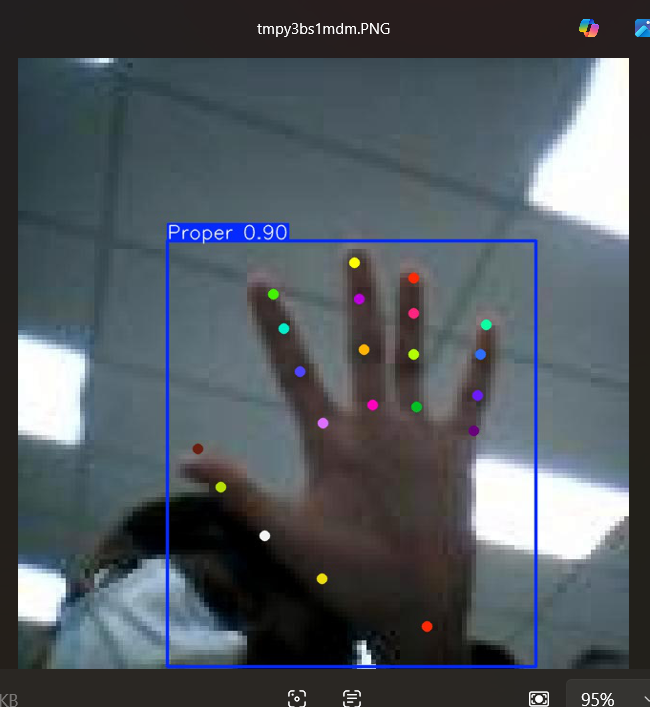

In [ ]:
import random
from PIL import Image

all_val_images = []
for img_dir in [val_proper_images_dir, val_improper_images_dir]:
    images = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_val_images.extend([(os.path.join(img_dir, f), img_dir) for f in images])

if all_val_images:
    img_path, img_dir = random.choice(all_val_images)
    
    results = prediction_model.predict(
        source=img_path,
        save=False,
        show=False,
        conf=prediction_confidence_threshold,
        show_labels=True,
        show_conf=True,
        show_boxes=True,
        line_width=2,
    )

    r = results[0]
    pred_class = None
    if r.boxes and hasattr(r.boxes, 'cls'):
        pred_class_idx = int(r.boxes.cls[0]) if len(r.boxes.cls) > 0 else None
        pred_class = prediction_model.names[pred_class_idx] if pred_class_idx is not None else "Unknown"
    else:
        pred_class = "No Detection"

    pred_img = r.plot()
    img_pil = Image.fromarray(pred_img)
    img_pil.show(title=f"Prediction: {pred_class} ({os.path.basename(img_path)})")
else:
    print("No validation images found for prediction.")

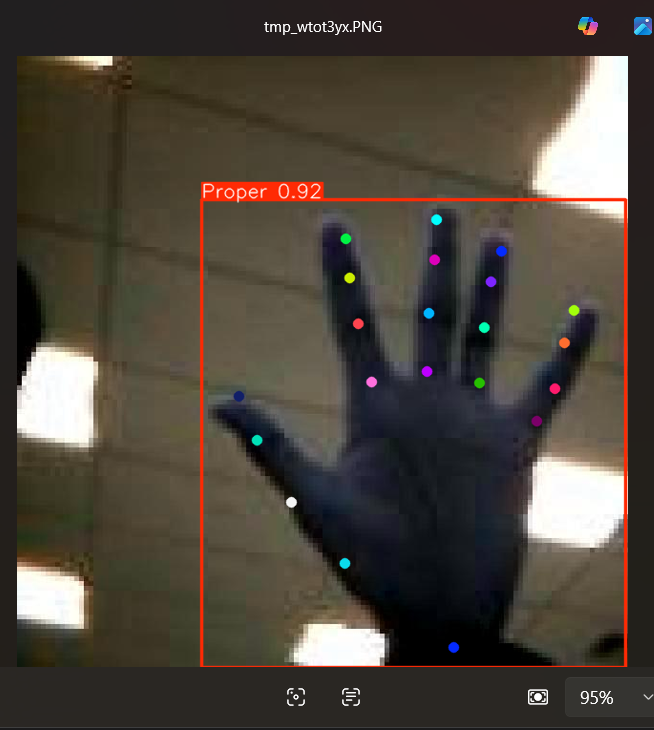

In [ ]:
# Cell 9: Final Inference Time Summary and Script Conclusion

logger.info("\n--- FINAL INFERENCE TIME SUMMARY ---")

if 'image_paths_to_predict' in locals() and image_paths_to_predict and prediction_model:
    try:
        
        single_image_path = random.choice(image_paths_to_predict)
        logger.info(f"Benchmarking inference speed on a single image: {os.path.basename(single_image_path)}")

        
        if device == 'cuda':
            _ = prediction_model.predict(source=single_image_path, verbose=False, device=device)
            torch.cuda.synchronize() 

        start_single_inference_time = time.time()
        _ = prediction_model.predict(source=single_image_path, verbose=False, device=device)
        if device == 'cuda':
            torch.cuda.synchronize() 
        end_single_inference_time = time.time()

        single_inference_time_ms = (end_single_inference_time - start_single_inference_time) * 1000
        logger.info(f"Single image inference time: {single_inference_time_ms:.2f} ms")
    except Exception as e:
        logger.error(f"Error during final inference time measurement: {e}", exc_info=True)
else:
    logger.warning("No images were predicted or trained model not available, skipping final inference time summary.")

logger.info("\n--- Script finished successfully! ---")

2025-05-22 18:17:28,949 - INFO - 
--- FINAL INFERENCE TIME SUMMARY ---
2025-05-22 18:17:28,950 - INFO - Benchmarking inference speed on a single image: hand5_j_dif_seg_4_cropped_jpeg_jpg.rf.c7a3add287b8534dbc9e47dfa0b8a74c.jpg
2025-05-22 18:17:29,129 - INFO - Single image inference time: 178.88 ms
2025-05-22 18:17:29,129 - INFO - 
--- Script finished successfully! ---


In [ ]:
#  Cell 10: FPS Measurement for Prediction Model

import time

if 'prediction_model' in locals() and 'image_paths_to_predict' in locals() and image_paths_to_predict:
    num_images = len(image_paths_to_predict)
    
    if prediction_model.device.type == 'cuda':
        _ = prediction_model.predict(source=image_paths_to_predict[0], verbose=False)
        torch.cuda.synchronize()
    start_time = time.time()
    _ = prediction_model.predict(source=image_paths_to_predict, verbose=False)
    if prediction_model.device.type == 'cuda':
        torch.cuda.synchronize()
    end_time = time.time()
    elapsed = end_time - start_time
    fps = num_images / elapsed if elapsed > 0 else 0
    print(f"Processed {num_images} images in {elapsed:.2f} seconds. FPS: {fps:.2f}")
else:
    print("Prediction model or image paths not available for FPS measurement.")

Processed 4 images in 1.75 seconds. FPS: 2.29


In [ ]:
# Cell 11: Confidence Score Distribution Plot (Saving to File)

num_images_for_conf_plot = 100 
plot_filename = 'confidence_distribution_histogram.png' 


if 'prediction_model' not in locals() or prediction_model is None:
    logger.error("Error: 'prediction_model' is not loaded. Cannot generate confidence distribution plot.")

elif 'val_proper_images_dir' not in locals() or 'val_improper_images_dir' not in locals():
    logger.error("Error: Validation image directories (val_proper_images_dir, val_improper_images_dir) are not defined. Cannot generate confidence distribution plot.")

elif 'pred_save_dir' not in locals() or not os.path.isdir(pred_save_dir):
    logger.error("Error: 'pred_save_dir' from previous prediction cell is not found or is invalid. Cannot save plot to designated folder.")
    logger.info("Please ensure Cell 8 (Prediction on Test Images) ran successfully and created 'pred_save_dir'.")
else:
    
    all_val_images_paths = []
    for img_dir in [val_proper_images_dir, val_improper_images_dir]:
        if os.path.isdir(img_dir):
            
            images = [os.path.join(img_dir, f) for f in os.listdir(img_dir)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            all_val_images_paths.extend(images)
        else:
            logger.warning(f"Validation image directory not found: '{img_dir}'. Skipping images from this path for plot analysis.")

    if not all_val_images_paths:
        logger.error("No valid validation images found in specified directories. Cannot generate confidence distribution plot.")
    else:
       
        sample_images_for_plot = random.sample(
            all_val_images_paths,
            min(num_images_for_conf_plot, len(all_val_images_paths))
        )
        logger.info(f"\n--- Generating Confidence Distribution Plot from {len(sample_images_for_plot)} Sample Images ---")

        
        all_collected_confidences = [] 
        for i, img_path in enumerate(sample_images_for_plot):
            
            if (i + 1) % 10 == 0 or (i + 1) == len(sample_images_for_plot):
                logger.info(f"  Processing image {i+1}/{len(sample_images_for_plot)}: {os.path.basename(img_path)}")
            try:
                
                current_device = 'cuda' if 'device' in locals() and device == 'cuda' else 'cpu'
                results = prediction_model.predict(
                    source=img_path,
                    save=False, show=False, verbose=False, 
                    conf=0.001, 
                    device=current_device
                )

                
                if results and len(results) > 0 and results[0].boxes:
                    all_collected_confidences.extend(results[0].boxes.conf.tolist())

            except Exception as e:
                logger.error(f"Error during inference on image {os.path.basename(img_path)} for confidence plot: {e}", exc_info=True)

        
        if not all_collected_confidences:
            logger.warning("No detections (even at conf=0.001) found across the sampled images. Skipping plot generation.")
        else:
            logger.info(f"Total confidence scores collected: {len(all_collected_confidences)} detections.")

            
            num_bins = 20 
            bins = np.linspace(0, 1, num_bins + 1) 
            bin_centers = (bins[:-1] + bins[1:]) / 2 

            
            plt.figure(figsize=(12, 7)) 
            plt.bar(bin_centers, hist, width=bins[1] - bins[0], color='skyblue', edgecolor='black', alpha=0.8)

        
            plt.xlabel('Confidence Score Bins', fontsize=12)
            plt.ylabel('Frequency (Number of Detections)', fontsize=12)
            plt.title(f'Distribution of Confidence Scores (from {len(sample_images_for_plot)} Sample Images)', fontsize=15, fontweight='bold')
            plt.xticks(np.arange(0, 1.01, 0.1), fontsize=10) 
            plt.yticks(fontsize=10)
            plt.grid(axis='y', linestyle='--', alpha=0.7) 
            plt.tight_layout() 
            
            plot_save_path = os.path.join(pred_save_dir, plot_filename)
            try:
                plt.savefig(plot_save_path, dpi=300, bbox_inches='tight') 
                logger.info(f"SUCCESS: Confidence distribution plot saved to: {plot_save_path}")
            except Exception as e:
                logger.error(f"FATAL ERROR: Could not save confidence distribution plot to {plot_save_path}: {e}", exc_info=True)

            plt.close() 

2025-05-22 19:15:13,252 - INFO - 
--- Generating Confidence Distribution Plot from 100 Sample Images ---


2025-05-22 19:15:16,407 - INFO -   Processing image 10/100: hand2_u_bot_seg_4_cropped_jpeg_jpg.rf.00efc869750a6de5252cc69a33475ef9.jpg
2025-05-22 19:15:17,153 - INFO -   Processing image 20/100: 90IMG__jpg.rf.e131e4b012ccc14fb746f85420232a1e.jpg
2025-05-22 19:15:18,302 - INFO -   Processing image 30/100: IMG20220224231025_jpg.rf.efa3e26b9004d1fa55db87d00bcc1ba9.jpg
2025-05-22 19:15:20,245 - INFO -   Processing image 40/100: hand5_g_dif_seg_5_cropped_jpeg_jpg.rf.5f4a60fd687e36bd3b41b61689f7a873.jpg
2025-05-22 19:15:22,643 - INFO -   Processing image 50/100: 36IMG__jpg.rf.46972cd949d84a3d52dfb241e1269739.jpg
2025-05-22 19:15:24,244 - INFO -   Processing image 60/100: 5-200-_png_jpg.rf.c7befe70fb2710ca0faaf1a8479c78f3.jpg
2025-05-22 19:15:25,383 - INFO -   Processing image 70/100: 0460_jpg.rf.5e4ebf82961f4d4469d6dfb6dac18240.jpg
2025-05-22 19:15:26,999 - INFO -   Processing image 80/100: hand5_o_bot_seg_1_cropped_jpeg_jpg.rf.82a50dc703ce01296e48e507cf5f82da.jpg
2025-05-22 19:15:29,091 - I

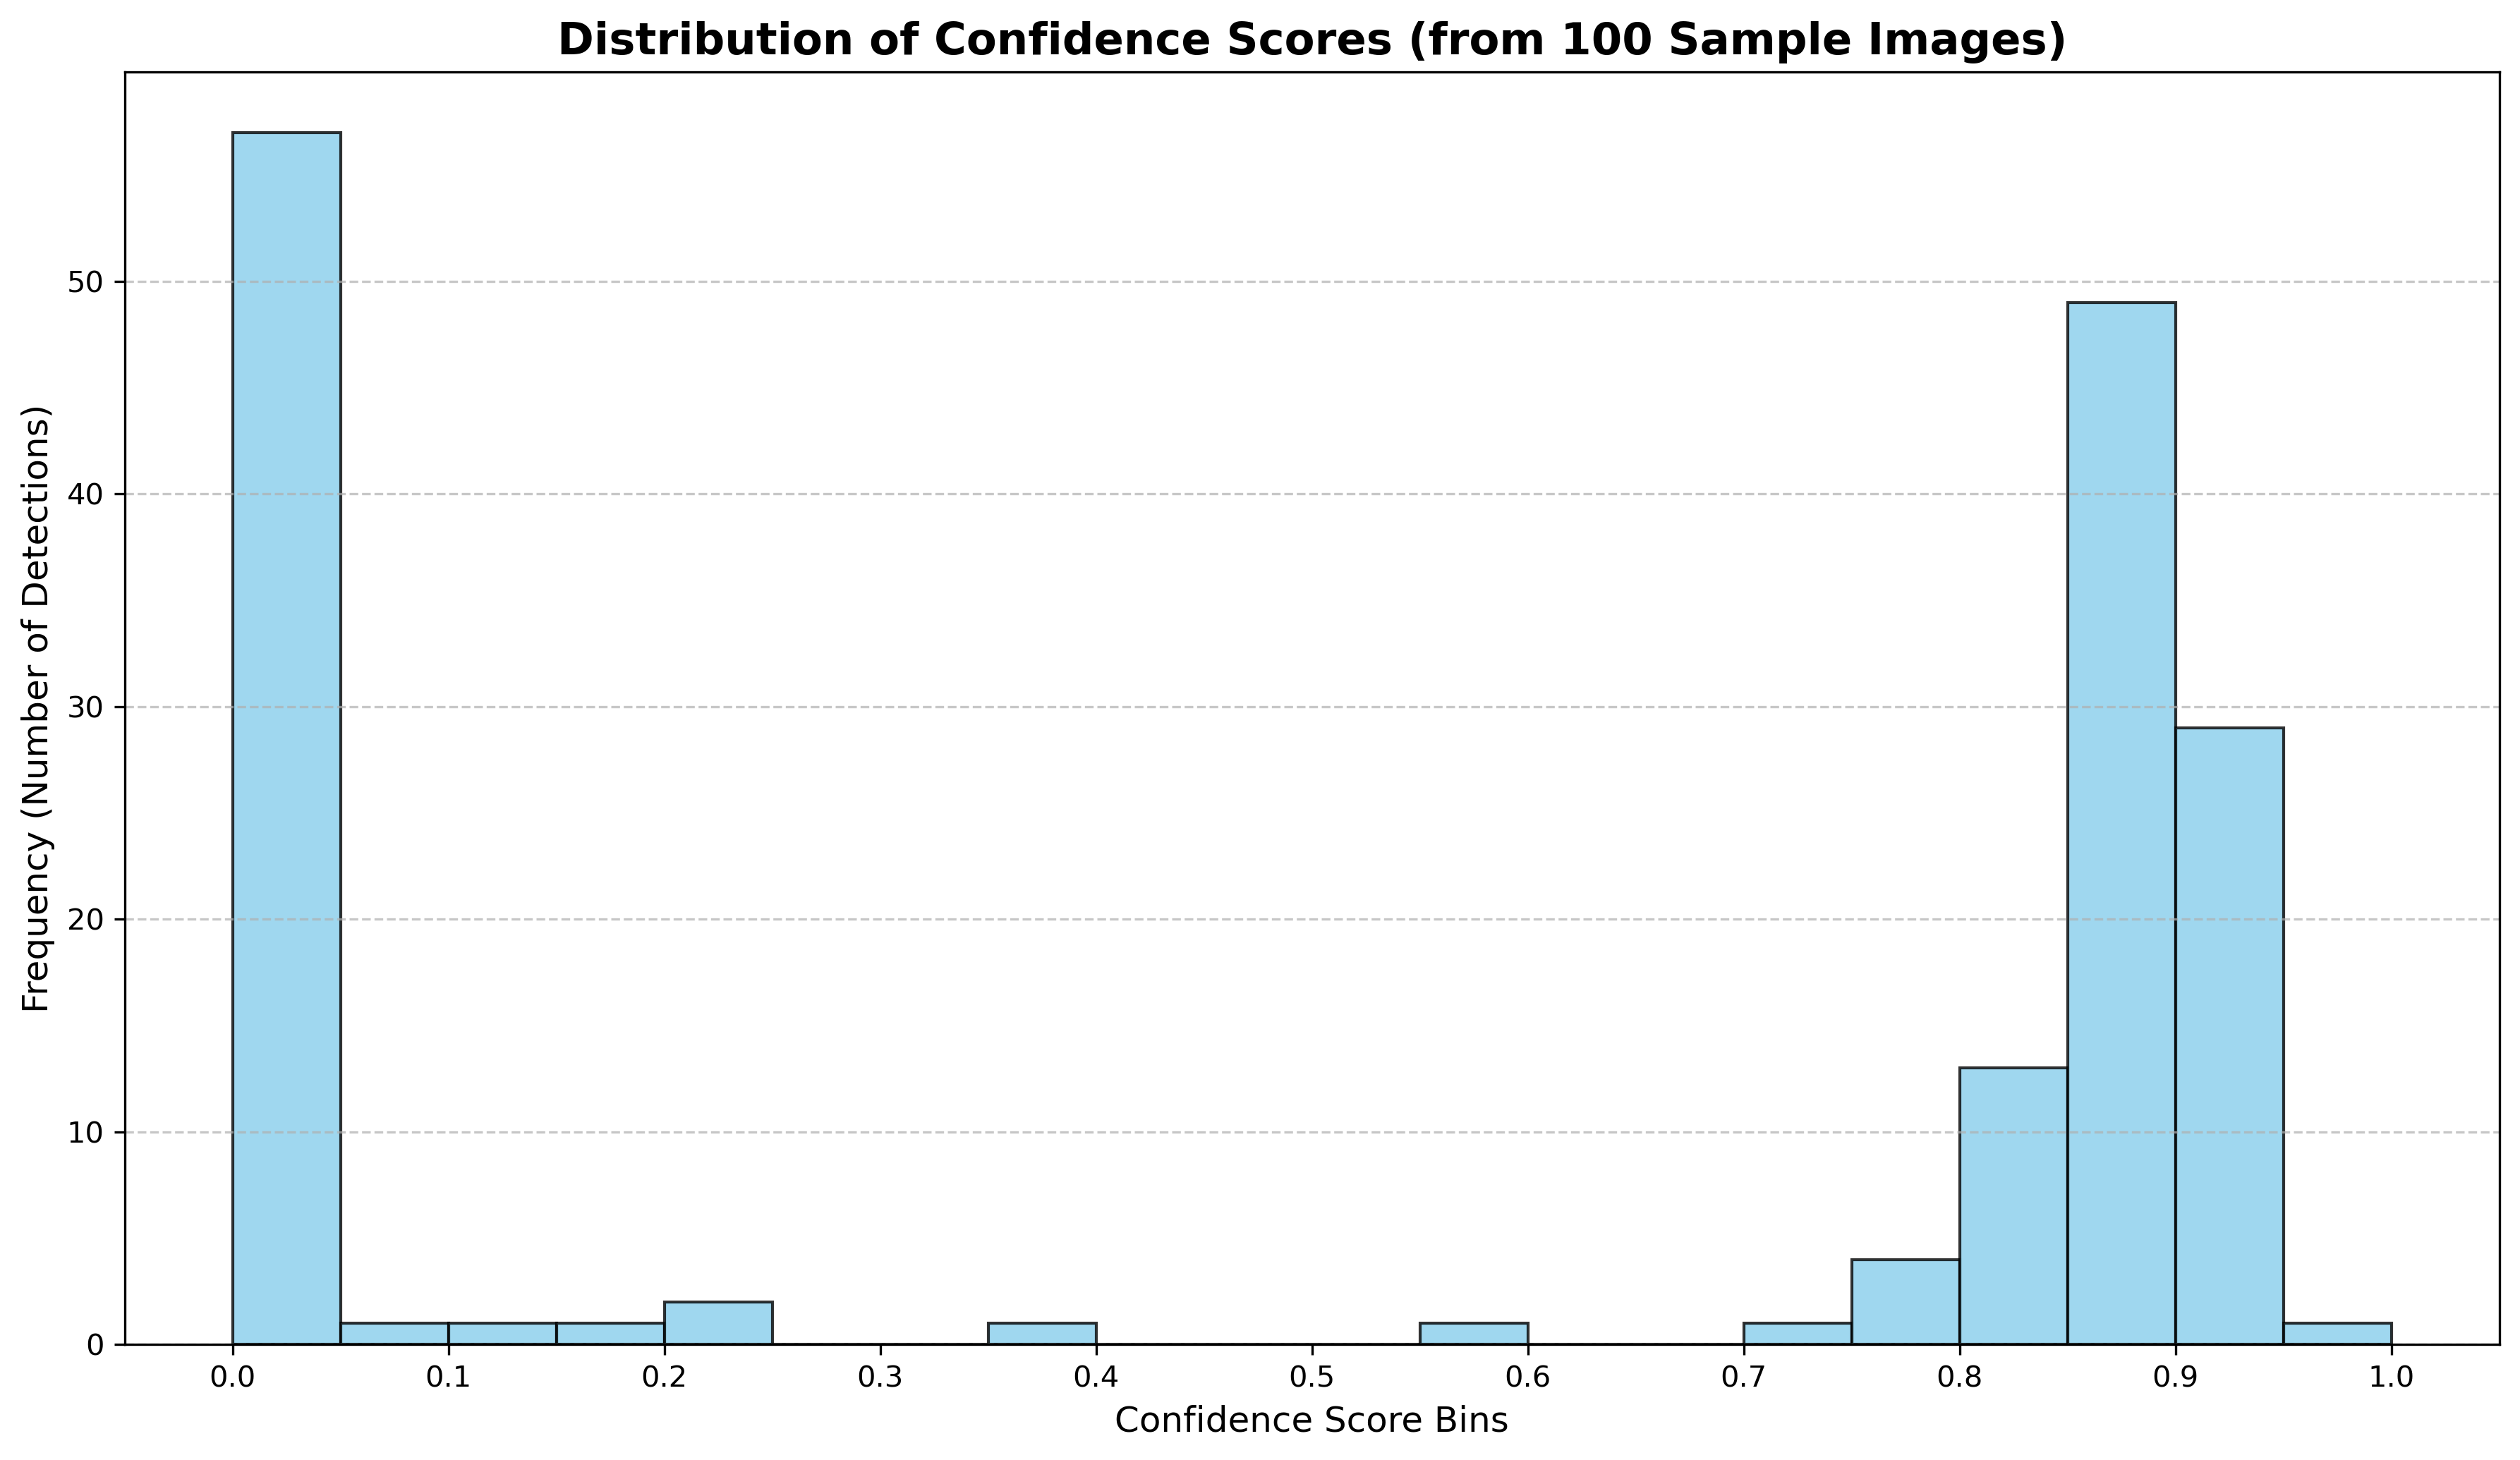

In [61]:
if 'logger' not in globals():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)


results_csv_path = os.path.join(
    r"C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\runs\hand_pose_training\yolov8n_custom_pose_20250522_110541",
    "results.csv"
)
plot_save_dir = r"C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\runs\hand_pose_training\yolov8n_custom_pose_20250522_110541_preds"
plot_filename = "custom_training_plots_pose_only.png" 
plot_save_path = os.path.join(plot_save_dir, plot_filename)


try:
    os.makedirs(plot_save_dir, exist_ok=True)
    logger.info(f"Ensured plot save directory exists: {plot_save_dir}")
except OSError as e:
    logger.error(f"Error creating plot save directory '{plot_save_dir}': {e}. Cannot save plot.")
    



if not os.path.exists(results_csv_path):
    logger.error(f"results.csv not found at {results_csv_path}. Cannot generate plots.")
else:
    try:
        df = pd.read_csv(results_csv_path)
        df.columns = df.columns.str.strip() 

        plt.figure(figsize=(18, 12)) 

        # Subplot 1: Losses vs. Epochs (Focus on Pose and Class Loss)
        plt.subplot(2, 2, 1)
        
        if 'train/pose_loss' in df.columns:
            plt.plot(df['epoch'], df['train/pose_loss'], label='Train Pose Loss', color='green')
        if 'val/pose_loss' in df.columns:
            plt.plot(df['epoch'], df['val/pose_loss'], label='Val Pose Loss', linestyle='--', color='green', alpha=0.7)
        if 'train/cls_loss' in df.columns: 
            plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', color='red')
        if 'val/cls_loss' in df.columns:
            plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss', linestyle='--', color='red', alpha=0.7)

        plt.title('Pose & Class Losses vs. Epochs', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss Value', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tick_params(axis='both', which='major', labelsize=10)

        # Subplot 2: Mean Average Precision (mAP) vs. Epochs (Pose Only)
        plt.subplot(2, 2, 2)
        if 'metrics/mAP50(P)' in df.columns:
            plt.plot(df['epoch'], df['metrics/mAP50(P)'], label='mAP50 (Pose)', color='cyan')
        if 'metrics/mAP50-95(P)' in df.columns:
            plt.plot(df['epoch'], df['metrics/mAP50-95(P)'], label='mAP50-95 (Pose)', color='magenta')
        else:
            logger.warning("No mAP for Pose (P) metrics found in results.csv. Check column names or training configuration.")

        plt.title('Mean Average Precision (mAP) for Pose vs. Epochs', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('mAP Value', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tick_params(axis='both', which='major', labelsize=10)

        # Subplot 3: Precision and Recall (Pose) vs. Epochs 
        plt.subplot(2, 2, 3) 
        if 'metrics/precision(P)' in df.columns and 'metrics/recall(P)' in df.columns:
            plt.plot(df['epoch'], df['metrics/precision(P)'], label='Precision (Pose)', color='lime')
            plt.plot(df['epoch'], df['metrics/recall(P)'], label='Recall (Pose)', color='firebrick')
            plt.title('Precision & Recall for Pose vs. Epochs', fontsize=14, fontweight='bold')
            plt.xlabel('Epoch', fontsize=12)
            plt.ylabel('Value', fontsize=12)
            plt.legend(fontsize=10)
            plt.grid(True, linestyle=':', alpha=0.6)
            plt.tick_params(axis='both', which='major', labelsize=10)
        else:
            plt.title('Precision & Recall (Pose) - Not Available', fontsize=14, fontweight='bold')
            plt.text(0.5, 0.5, "Pose metrics (P) not found in results.csv", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10, color='gray')
            logger.warning("Pose precision/recall metrics not found in results.csv. Skipping plot for pose metrics.")

       
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 

        try:
            plt.savefig(plot_save_path, dpi=300, bbox_inches='tight') 
            logger.info(f"SUCCESS: Pose-only training plots saved to: {plot_save_path}")
        except Exception as e:
            logger.error(f"FATAL ERROR: Could not save training plots to {plot_save_path}: {e}", exc_info=True)

        plt.show() 
        plt.close() 

    except Exception as e:
        logger.error(f"An unexpected error occurred while plotting training results: {e}", exc_info=True)
        if 'df' in locals():
            logger.error(f"Available columns in the loaded results.csv: {list(df.columns)}")
        else:
            logger.error("Failed to load results.csv DataFrame for plotting.")

2025-05-22 21:03:35,559 - INFO - Ensured plot save directory exists: C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\runs\hand_pose_training\yolov8n_custom_pose_20250522_110541_preds
2025-05-22 21:03:40,760 - INFO - SUCCESS: Pose-only training plots saved to: C:\Users\Weslie Jee Catulay\Downloads\Final Project for DataSciene\Final_dataset\runs\hand_pose_training\yolov8n_custom_pose_20250522_110541_preds\custom_training_plots_pose_only.png


<Figure size 1800x1200 with 3 Axes>

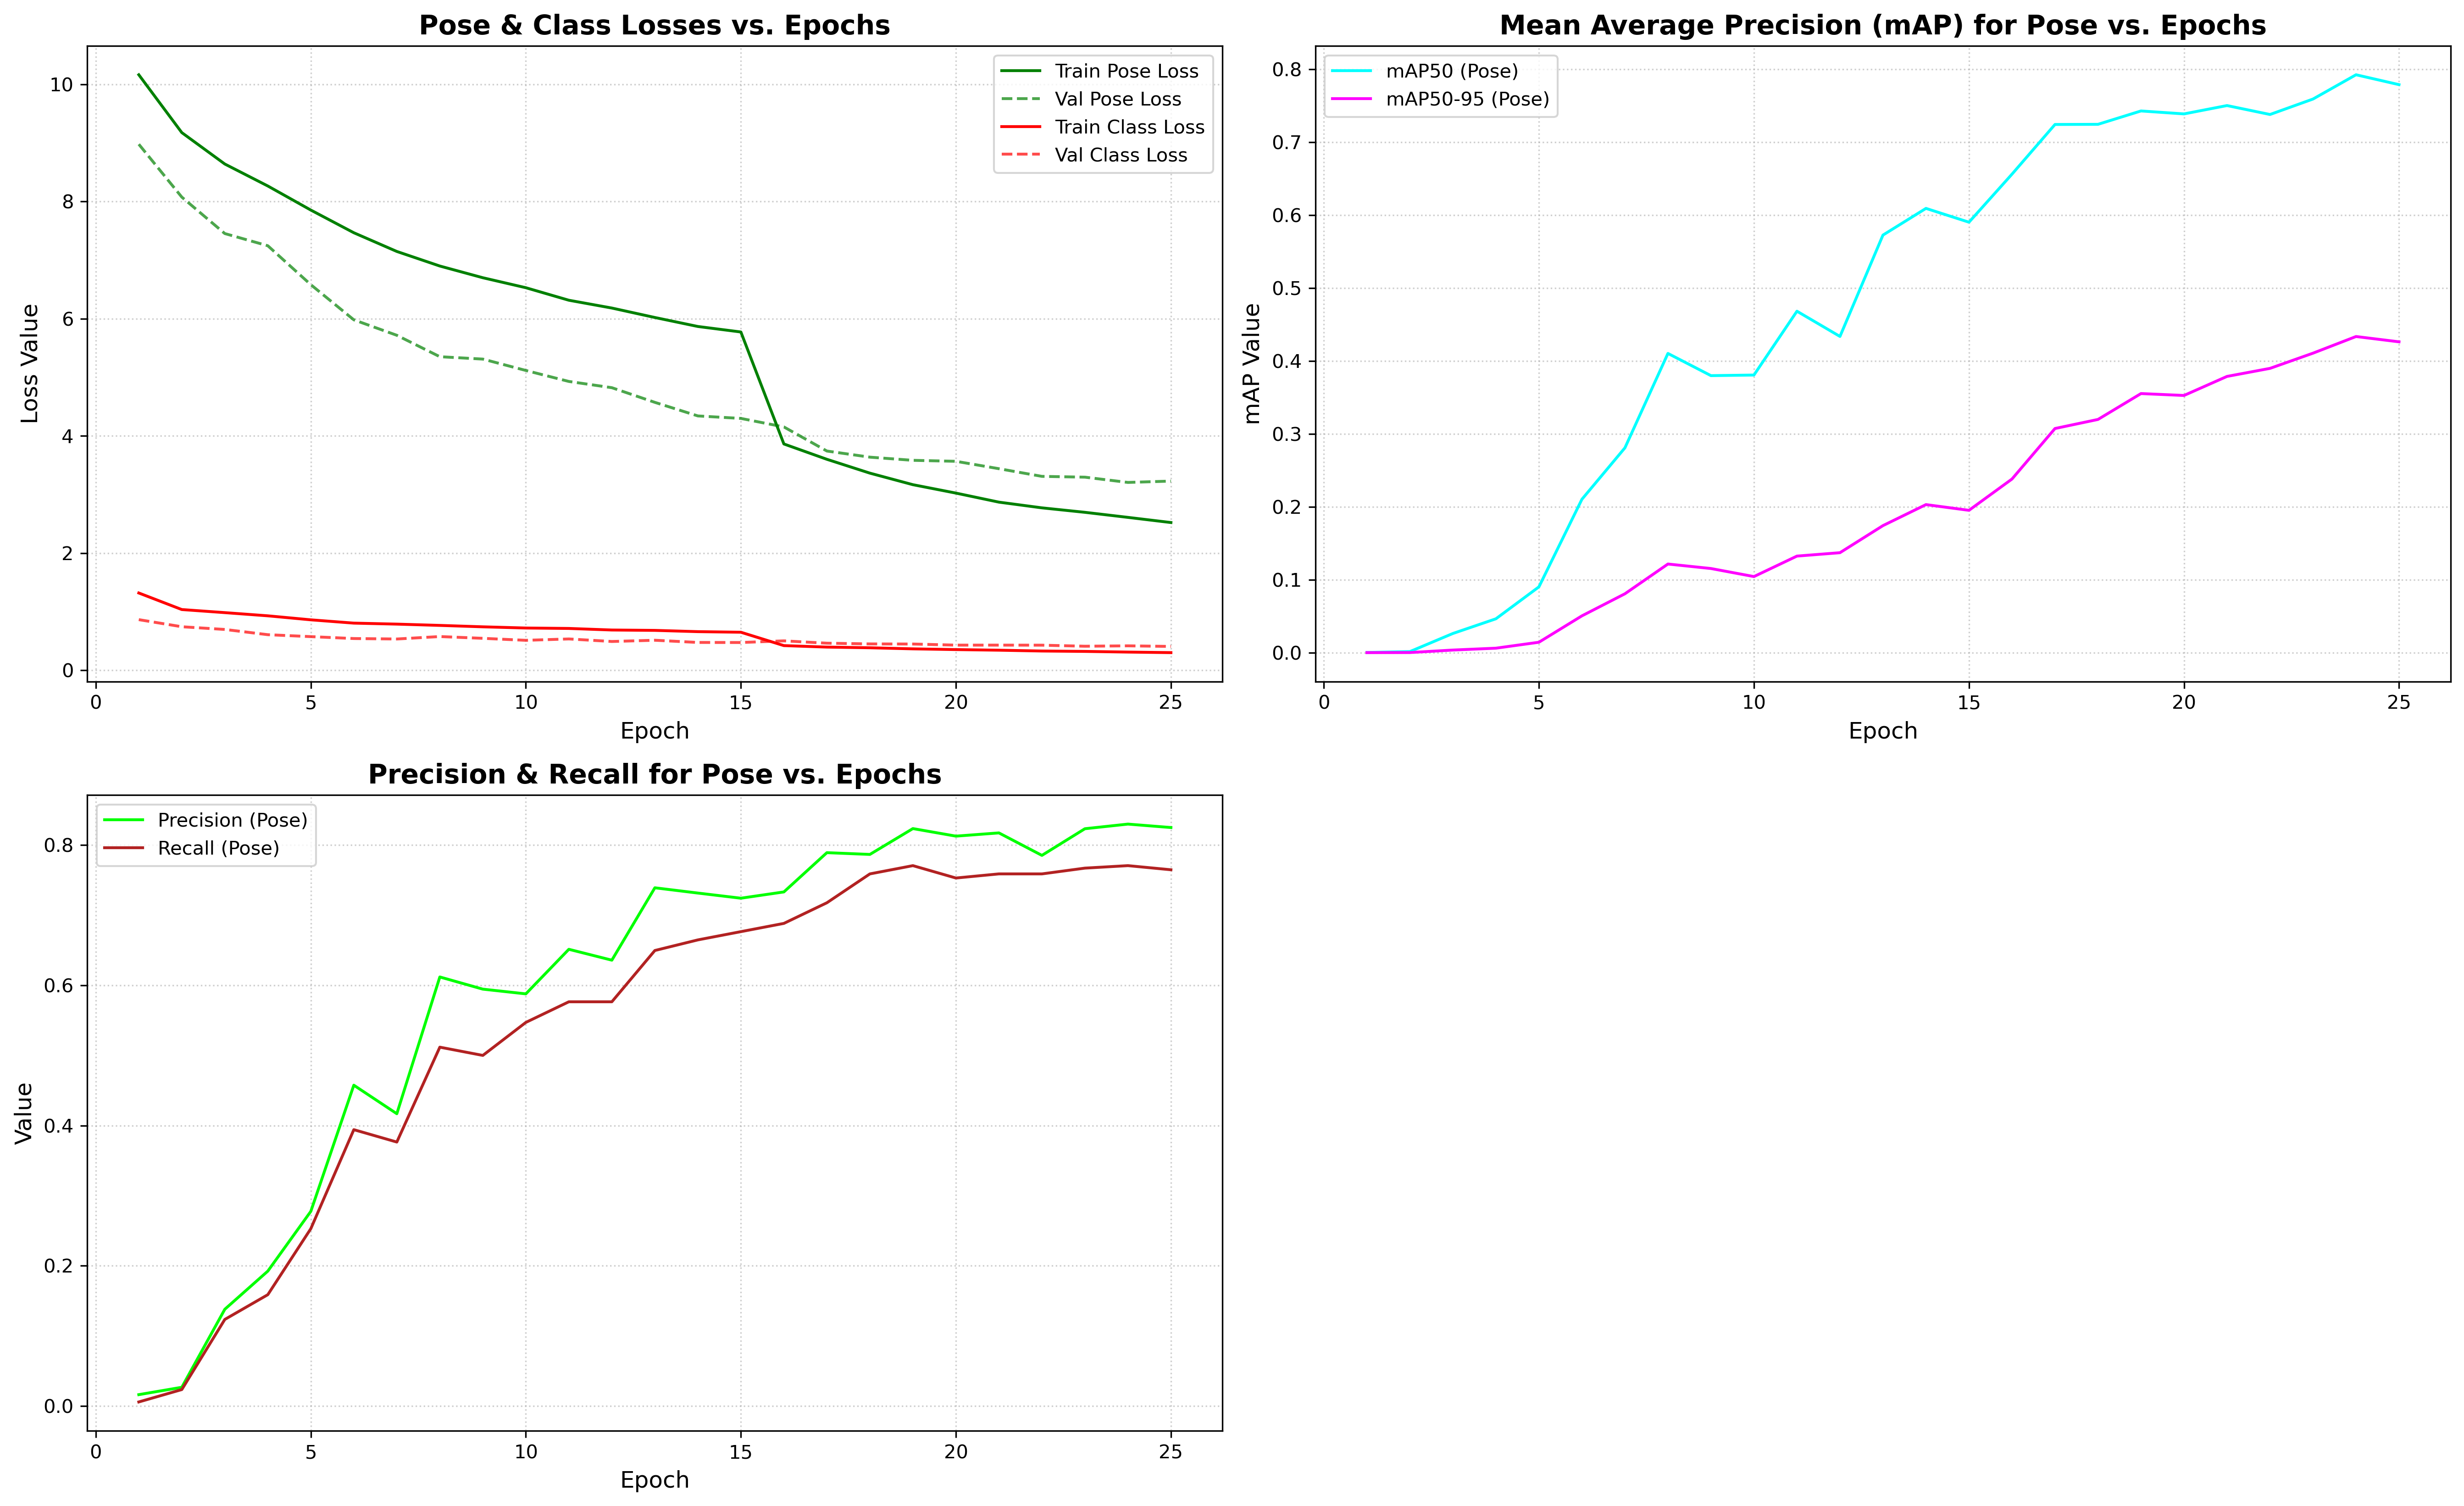

In [ ]:
save_path = os.path.join(experiment_run_dir, "weights", "YOLOv8_model.pt")
if prediction_model is not None:
    prediction_model.save(save_path)
    print(f"Model saved to: {save_path}")
else:
    print("No trained model available to save.")

_______________________________________________________________________________________________________________________________________________________________

_______________________________________________________________________________________________________________________________________________________________

_______________________________________________________________________________________________________________________________________________________________

_______________________________________________________________________________________________________________________________________________________________